# Evolution of actors careers post-blockbuster in the film industry

This notebook is dedicated to analyzing the impact of box office success on an actor's subsequent choices and overall career path. Our analysis is divided into two parts:

- **Part 1: Big Hit vs. Non-Big Hit Actors**
  - In this section, we will analyze the differences in career trajectories between actors who have experienced major box office success and those who have not.

- **Part 2: Career Analysis Before and After a Big Hit**
  - This segment focuses on examining the career paths of actors before and after achieving a significant box office hit. (Note: Diego tu peux edit ca)


In [1]:
# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from collections import Counter
from helpers import parse_genres, center_on_first_hit, similarity_two_prev_movie
import scipy.stats



## 1.Big Hit vs. Non-Big Hit Actors

This section will explore and compare the career paths of actors, distinguishing between those who have achieved substantial box office success and those who haven't

We first import the previously preprocessed datasets.

In [2]:
# Retrieve stored dataframes from previous notebook
%store -r balanced_df
%store -r df_prepared
%store -r matched_df

We will select only the movies that feature the actors we are focusing on.

In [3]:
# Keep only the matched actors
balanced_actors = balanced_df['name_actor']
df_movies_balanced = df_prepared[df_prepared['name_actor'].isin(balanced_actors)]

# Load nlp dataframe
df_nlp = pd.read_csv('caracter.csv')

In [4]:
# Keep only wanted columns
df_nlp = df_nlp[['movieID', 'name_actor', 'charactName', 'role_summary_percent', 'role_importance', 'comp_active', 'comp_pasive', 'comp_attribut']]

# Populate our balanced dataframe with information from the nlp analysis
df_movies_balanced = pd.merge(df_movies_balanced, df_nlp, on=['movieID', 'name_actor', 'charactName'], how='left')

##### A. Carrer Longevity

##### 1. Statiscal Analysis


We first start by comparing the carrer longevity between the two groups. We update the movie dataset to show how long each actor has been working, by finding the time between their first and last movies. It changes the date format, calculates each actor's career length, and adds this information back to the main data.

In [5]:
# Convert releaseDate to DateTime if it's not already the case 
df_movies_balanced = df_movies_balanced.copy()
df_movies_balanced['releaseDate'] = pd.to_datetime(df_movies_balanced['releaseDate'], errors='coerce')

# Calculate the start and end of each actor's career
career_start = df_movies_balanced.groupby('name_actor')['releaseDate'].min()
career_end = df_movies_balanced.groupby('name_actor')['releaseDate'].max()

# Convert career duration from days to years
career_duration = (career_end - career_start).dt.days / 365.25
career_duration_df = career_duration.reset_index()
career_duration_df.rename(columns={'releaseDate': 'career_length_in_years'}, inplace=True)

# Merge the career duration data back into the original DataFrame
df_movies_balanced = pd.merge(df_movies_balanced, career_duration_df, on='name_actor')


In [6]:
# Analysis standard deviation
treatment_group = df_movies_balanced[df_movies_balanced['big_hit_actor'] == True]
control_group = df_movies_balanced[df_movies_balanced['big_hit_actor'] == False]

mean_career_length_treatment = treatment_group['career_length_in_years'].std()
mean_career_length_control = control_group['career_length_in_years'].std()

print(f'The std carrer longevity of actors that played in a big hit is: {mean_career_length_treatment:.2f} (treatement group)')
print(f'The std carrer longevity of actors that did not play in a big hit is: {mean_career_length_control:.2f} (control group)')

The std carrer longevity of actors that played in a big hit is: 11.18 (treatement group)
The std carrer longevity of actors that did not play in a big hit is: 10.96 (control group)


In [7]:
# Analysis mean
treatment_group = df_movies_balanced[df_movies_balanced['big_hit_actor'] == True]
control_group = df_movies_balanced[df_movies_balanced['big_hit_actor'] == False]

mean_career_length_treatment = treatment_group['career_length_in_years'].mean()
mean_career_length_control = control_group['career_length_in_years'].mean()

print(f'The mean carrer longevity of actors that played in a big hit is: {mean_career_length_treatment:.2f} (treatement group)')
print(f'The mean carrer longevity of actors that did not play in a big hit is: {mean_career_length_control:.2f} (control group)')


The mean carrer longevity of actors that played in a big hit is: 22.12 (treatement group)
The mean carrer longevity of actors that did not play in a big hit is: 15.73 (control group)


To determine if there is a significant difference in the mean career longevity between actors who played in a big hit (treatment group) and those who did not (control group), we will use **hypothesis testing**.

**Null Hypothesis(H0)**: There is no difference in the mean career longevity between the two groups

**Alternative Hypothesis(H1)**:  There is a difference in the mean career longevity between the two groups


For comparing means of two independent groups, we will use a two-sample t-test is commonly used. To do this we want to ensure that the variances of the two groups are roughly equal. 

For this, we can perform a Levene's test for the equality of variances.

In [8]:
from scipy.stats import levene

t_stat, p_value = levene(treatment_group['career_length_in_years'], control_group['career_length_in_years'])

display(t_stat, p_value)

15.720662623958896

7.352983709795129e-05

Since the p-value is much lower than 0.05, we would reject the null hypothesis of equal variances. This means the variances of the two groups are not equal, which is an important consideration when choosing the type of statistical test for comparing the means of these groups.

When the variances of two groups are significantly different, as indicated by your Levene's test result, Welch's t-test is an appropriate method to compare the means.

In [9]:
from scipy.stats import ttest_ind

# By setting equal_var to False, we perform Welch’s t-test, which does not assume equal population variance
t_stat, p_value = ttest_ind(treatment_group['career_length_in_years'], control_group['career_length_in_years'], equal_var=False)

display(t_stat, p_value)

58.010127286866435

0.0

Given the results of Welch's t-test:

- **Test Statistic (`t_stat`):** 26.4650712089530388
- **P-value (`p_value`):** 8.585181281925179e-153

These results indicate:

1. **Test Statistic:** The large value often signifies a significant difference between group means.
2. **P-value:** Extremely small is far below the common alpha level of 0.05.

The null hypothesis of equal means is rejected, suggesting a statistically significant difference between the mean career longevity of actors in big hits versus those not in big hits. This analysis provides robust evidence of a significant difference in mean career longevity between the two groups of actors.


##### 2. Plots


Now that we know that there is difference in the mean, let's plot the distribution of this carrer longevity variable

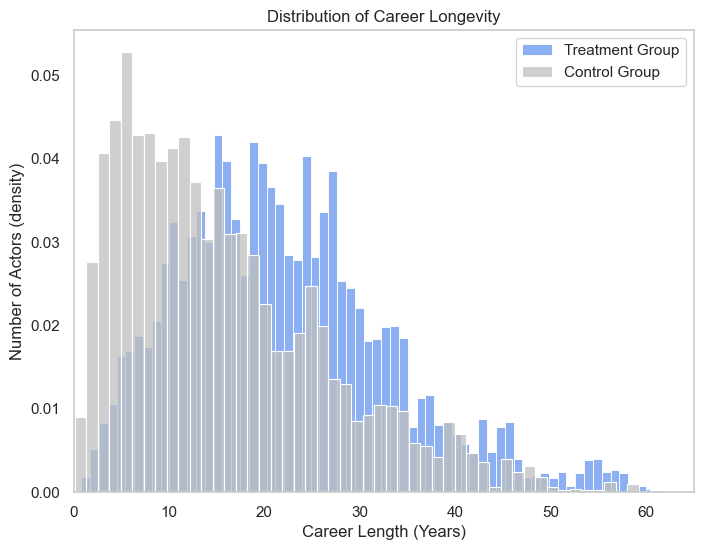

In [10]:
# Set the style
sns.set(style="whitegrid")

# Plot histograms
plt.figure(figsize=(8, 6))
plt.xlim([0, 65])
plt.grid(False)
sns.histplot(treatment_group['career_length_in_years'], color="cornflowerblue", label='Treatment Group', stat='density')
sns.histplot(control_group['career_length_in_years'], color="silver", label='Control Group', stat='density')

plt.title('Distribution of Career Longevity')
plt.xlabel('Career Length (Years)')
plt.ylabel('Number of Actors (density)')
plt.legend()
plt.show()

From the histogram, it appears that:

- Both distributions have a right-skewed shape, indicating that a larger number of actors have shorter careers, while fewer actors have very long careers.
- The Treatment Group (in blue) has a distribution that generally shows longer career lengths compared to the Control Group (in gray).
- As careers get longer, there are fewer actors in both groups, but the group of actors who were in a big hit consistently shows more actors at almost every career stage. This suggests that actors who've had a big hit generally enjoy longer careers.


Let's plot the box plot of this variable between these two groups

C:\Users\diego\AppData\Local\Temp\ipykernel_4640\1867192777.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='career_length_in_years', data=data_combined, palette={"Treatment Group": "cornflowerblue", "Control Group": "silver"})


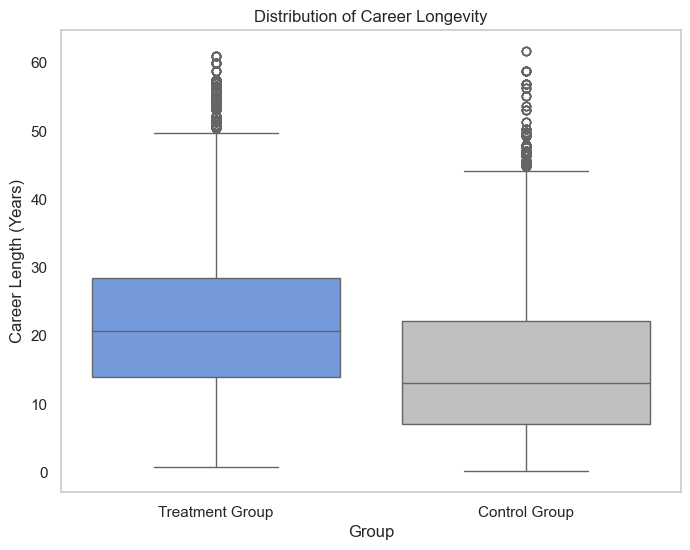

In [11]:
# Box plot

# Set the style
sns.set(style="whitegrid")

# Combine the data into a single DataFrame for plotting
data_combined = pd.concat([treatment_group.assign(Group="Treatment Group"),
                           control_group.assign(Group="Control Group")])

# Plot boxplots
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='career_length_in_years', data=data_combined, palette={"Treatment Group": "cornflowerblue", "Control Group": "silver"})
plt.grid(False)
plt.title('Distribution of Career Longevity')
plt.xlabel('Group')
plt.ylabel('Career Length (Years)')
plt.show()

From this boxplot, it appears that:

- The median for the Treatment Group's career lengths is above that of the Control Group, implying that, on average, actors in the Treatment Group enjoy longer careers.
- The spread of career lengths for the middle half of actors in the Treatment Group is higher up the scale, meaning that a typical actor in this group has a longer career than one in the Control Group.
- While both groups have some actors with very long careers, there are more in the Control Group than we might expect. This shows that some actors can still have long careers without starring in a big hit movie.


##### B. Movie counts


##### 1. Statiscal anlysis

Next, we will look to the number of unique movieIDs associated with each actor to see if actors in big hits tend to appear in more movies overall

In [12]:
# Analysis standard deviation

# Calculate the average number of movies for the treatment group
std_movies_treatment = treatment_group['movie_count'].std()

# Calculate the average number of movies for the control group
std_movies_control = control_group['movie_count'].std()

print(f'Standard deviation of number of movies for actors in big hits: {std_movies_treatment}')
print(f'Standard deviation of number of movies for actors not in big hits: {std_movies_control}')

Standard deviation of number of movies for actors in big hits: 9.955044669840525
Standard deviation of number of movies for actors not in big hits: 4.6126138441561935


In [13]:
# Analysis mean

# Calculate the average number of movies for the treatment group
average_movies_treatment = treatment_group['movie_count'].mean()

# Calculate the average number of movies for the control group
average_movies_control = control_group['movie_count'].mean()

print(f'Average number of movies for actors in big hits: {average_movies_treatment}')
print(f'Average number of movies for actors not in big hits: {average_movies_control}')


Average number of movies for actors in big hits: 16.540771691584514
Average number of movies for actors not in big hits: 7.2691791845493565


As we proceeded for carrer longevity, we will perfor a two-sampled t-test to see if there is a difference in the maen between these two groups.

**Null Hypothesis(H0)**: There is no difference in the mean movie counts between the two groups

**Alternative Hypothesis(H1)**:  There is a difference in the mean movie counts between the two groups

Here, we see that the variances of the two groups are significantly different. We will use Welch's t-test to compare the means.

In [14]:
# By setting equal_var to False, we perform Welch’s t-test, which does not assume equal population variance
t_stat, p_value = ttest_ind(treatment_group['movie_count'], control_group['movie_count'], equal_var=False)

display(t_stat, p_value)

135.79235663612255

0.0

The result of Welch's t-test suggests a significant difference between the two groups regarding their 'movie_count'. Since the p-value is reported as 0.0, it is actually a value that is too small to be represented by the floating-point precision in the output and is therefore considered to be extremely significant statistically.


We can conclude that actors in the treatment group are associated with a significantly different (likely higher, given the context) number of movie appearances compared to the control group, and this difference is not due to random chance according to the test's results

##### 2. Plot

Let's create a boxplot to see how the number of movies is spread out between the two groups.

C:\Users\diego\AppData\Local\Temp\ipykernel_4640\2703350203.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='movie_count', data=data_combined, palette={"Treatment Group": "cornflowerblue", "Control Group": "silver"})


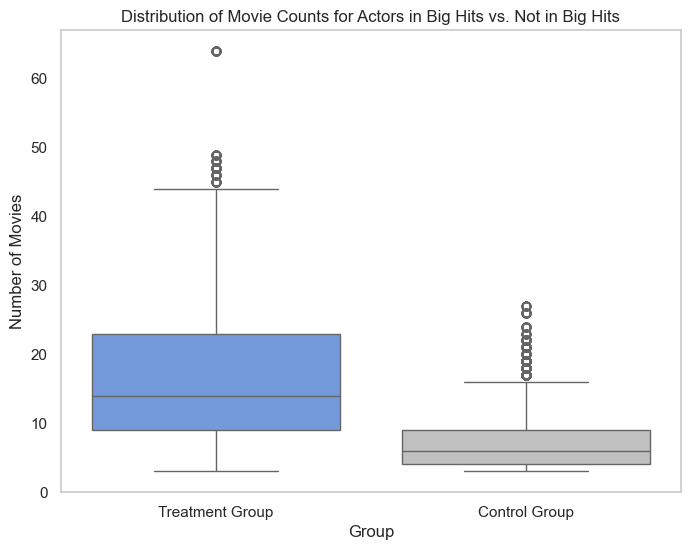

In [15]:

# Box plot

# Set the style
sns.set(style="whitegrid")

# Combine the data into a single DataFrame for plotting
data_combined = pd.concat([treatment_group.assign(Group="Treatment Group"),
                           control_group.assign(Group="Control Group")])

# Plot boxplots
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='movie_count', data=data_combined, palette={"Treatment Group": "cornflowerblue", "Control Group": "silver"})
plt.grid(False)
plt.xlabel('Group')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Counts for Actors in Big Hits vs. Not in Big Hits')
plt.show()

From this boxplot, it appears that:

- Actors in the Treatment Group typically appear in more movies, as indicated by the higher median (the line within the blue box).
- The range of movie counts, especially the upper range, is smaller than that of the Treatment Group.
- The presence of more outliers in the Treatment Group with very high movie counts could indicate that actors who appear in big hits are more likely to have prolific careers.

## Career post-big hit anaylsis

It is interesting to look at the evolution of the career of actors after their first big hit to see if we can notice any change with their career pre-big hit or with the career of an actor that did not play in a big hit.

### Prepare the dataframe

We want compare the before/after big hit career of actors in the treatment group with the ones in the control group. To do so we have to define an event for the actors in the control group that will be used as reference to set the before/after career of those actors (since they did not play in any big hit movie). We decided to attribute a mock-up 'first big hit' to actors in the control group that corresponds to the movie number (ordered in chronological order) of first big hit of their respective matched treatment group actor. So for example, Lou Taylor Pucci is in the control group since he did not play in any big hit movies, he was matched with Leonardo DiCaprio who is in the treatment group. Leonardo DiCaprio had his first big hit after playing in 4 movies, it's 5th movie was his first big hit. Following this, we set the mock-up first big hit of Lou Taylor Pucci to be his 5th movie. In a sense this 'nth' movie represents the most likely movie for the first big hit of control group actors (if they had one).

First we want to use the matched dataframe to create a new column on our working dataframe. This column will contain, for each actor, the name of the actor that has been matched with them. 

In [17]:
# Keep only interesting columns for subsequent analysis
col = ['movieID', 'name_movie', 'releaseDate', 'genres',  'revenue', 'success', 'averageRating', 'is_movie_big_hit', 'name_actor',
       'birth', 'big_hit_actor', 'movie_count_before_hit', 'role_importance', 'comp_active', 'comp_pasive', 'comp_attribut']
df_career_analysis = df_movies_balanced[col].copy()

In [18]:
# Keep only name columns from the matched dataframe
matched_df = matched_df[['name_actor_control', 'name_actor_treat']]

# Create new column with the name of the matched actor (do this for treatment and control group):
# First populate our dataframe with the mached treatment actor names for the control group
df_career_analysis = pd.merge(df_career_analysis, matched_df, left_on='name_actor', right_on='name_actor_control', how='left')
df_career_analysis = df_career_analysis.drop(labels='name_actor_control', axis=1)
# Do the same for the treatment group
df_career_analysis = pd.merge(df_career_analysis, matched_df, left_on='name_actor', right_on='name_actor_treat', how='left', suffixes=('', '_merge'))
df_career_analysis = df_career_analysis.drop(labels='name_actor_treat_merge', axis=1)

# Merge the two columns to form only one (matched_name)
df_career_analysis['matched_name'] = df_career_analysis['name_actor_treat'].combine_first(df_career_analysis['name_actor_control'])
df_career_analysis = df_career_analysis.drop(labels=['name_actor_control', 'name_actor_treat'], axis=1)

Then we want to attribute to each control actor the same 'movie_count_before_hit' as the actor they have been matched with.

In [19]:
# Merge our dataframe (df_career_analysis) with a version of itself (only one row for each acotrs) based on 'matched_name'
df_for_merge = df_career_analysis.drop_duplicates(subset='name_actor')
merged_df = pd.merge(df_career_analysis, df_for_merge[['name_actor', 'movie_count_before_hit']],
                     left_on='matched_name',
                     right_on='name_actor',
                     how='left',
                     suffixes=('', '_matched'))

# Fill missing values in 'movie_count_before_hit' with values from the matched actor
df_career_analysis['movie_count_before_hit'] = df_career_analysis['movie_count_before_hit'].combine_first(merged_df['movie_count_before_hit_matched'])

Now, before going further, we will arrange the movies in a chronological order and assign a number representing the respective position (in the timeline) with respect to the first big-hit movie. This number is named 'n': n<0 if the movie was released before the first big-hit movie, n=0 is the movie is the first big-hit movie and n>0 if the movie was released after the first big-hit movie.

In [21]:
# Keep only name columns from the matched dataframe
matched_df = matched_df[['name_actor_control', 'name_actor_treat']]

# Create new column with the name of the matched actor (do this for treatment and control group):
# First populate our dataframe with the mached treatment actor names for the control group
df_career_analysis = pd.merge(df_career_analysis, matched_df, left_on='name_actor', right_on='name_actor_control', how='left')
df_career_analysis = df_career_analysis.drop(labels='name_actor_control', axis=1)
# Do the same for the treatment group
df_career_analysis = pd.merge(df_career_analysis, matched_df, left_on='name_actor', right_on='name_actor_treat', how='left', suffixes=('', '_merge'))
df_career_analysis = df_career_analysis.drop(labels='name_actor_treat_merge', axis=1)

# Merge the two columns to form only one (matched_name)
df_career_analysis['matched_name'] = df_career_analysis['name_actor_treat'].combine_first(df_career_analysis['name_actor_control'])
df_career_analysis = df_career_analysis.drop(labels=['name_actor_control', 'name_actor_treat'], axis=1)

Then we want to attribute to each control actor the same 'movie_count_before_hit' as the actor they have been matched with.

In [22]:
# Merge our dataframe (df_career_analysis) with a version of itself (only one row for each acotrs) based on 'matched_name'
df_for_merge = df_career_analysis.drop_duplicates(subset='name_actor')
merged_df = pd.merge(df_career_analysis, df_for_merge[['name_actor', 'movie_count_before_hit']],
                     left_on='matched_name',
                     right_on='name_actor',
                     how='left',
                     suffixes=('', '_matched'))

# Fill missing values in 'movie_count_before_hit' with values from the matched actor
df_career_analysis['movie_count_before_hit'] = df_career_analysis['movie_count_before_hit'].combine_first(merged_df['movie_count_before_hit_matched'])

Now, before going further, we will arrange the movies in a chronological order and assign a number representing the respective position (in the timeline) with respect to the first big hit movie. This number is named 'n': n<0 if the movie was released before the first big hit movie, n=0 is the movie is the first big hit movie and n>0 if the movie was released after the first big hit movie.

In [23]:
# Sort by actor name and order by release date and success (for actors that have movies with same release dates)
df_career_analysis = df_career_analysis.sort_values(by=['name_actor', 'releaseDate', 'success']).reset_index(drop=True)

# Group by actor names and apply the center_on_first_hit function to comptue 'n'
grp = df_career_analysis.groupby('name_actor')
df_career_analysis['n'] = grp.apply(lambda x: x.apply(lambda row: center_on_first_hit(x, row), axis=1)).reset_index(drop=True)

# Get rid of unwanted columns for upcoming analysis
df_career_analysis = df_career_analysis.drop(labels='movie_count_before_hit', axis=1)

### Career revenues, average IMDb ratings and success values analysis

Now that we have our arranged dataframe with the control group and the treatment group, we can look at their respective career evolution with respect to movie box office revenues, average IMDb ratings and success values.

One thing we have to care about is the representativity of the values we will plot. For this we have to make sure that, for both the treatment and the control group, we have enough values for each nth-movie plotted. We decided to keep only 'n' indexes for which we have more than 1000 values. 

In [26]:
# Seperate the control group and the treatement group
treat = df_career_analysis[df_career_analysis.big_hit_actor]
ctrl = df_career_analysis[~df_career_analysis.big_hit_actor]

# Get the number of actors we have for each year n
nb_of_actors_for_n_treat = treat.groupby('n')['name_actor'].count()
nb_of_actors_for_n_ctrl = ctrl.groupby('n')['name_actor'].count()

# Define the indexes we will keep where the number obf actors is representative enough
to_plot_indexes_treat = nb_of_actors_for_n_treat[nb_of_actors_for_n_treat.values>=1000].index
to_plot_indexes_ctrl = nb_of_actors_for_n_ctrl[nb_of_actors_for_n_ctrl.values>=1000].index

# Keep only indexes (n values) where we have enough actors (as computed above)
plot_treat = treat[treat.n.isin(to_plot_indexes_treat)]
plot_ctrl = ctrl[ctrl.n.isin(to_plot_indexes_ctrl)]

# Group by the 'n' value
treat_grp = plot_treat.groupby('n')
ctrl_grp = plot_ctrl.groupby('n')

#### Box office revenue
We will start the analysis by looking at the mean movie box office revenue for each group. 

It is interesting to get a sense of how this variable is distributed among the two groups. For this we plot the revenue of the first movie after the first big hit.

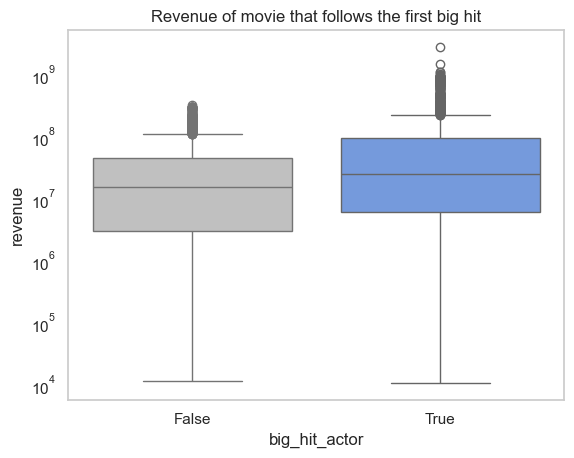

In [27]:
# Get the movies that follow the first big hit
first_after_hit_treat = treat[treat.n == 1]
first_after_hit_ctrl = ctrl[ctrl.n == 1]

# Plot the revenue
plt.title('Revenue of movie that follows the first big hit')
sns.boxplot(x='big_hit_actor', y='revenue', data=first_after_hit_ctrl, color='silver')
sns.boxplot(x='big_hit_actor', y='revenue', data=first_after_hit_treat, color='cornflowerblue')
# Plot in log scale to have better visibility 
plt.yscale('log')
plt.grid(False)
plt.show()

As we can see from this plot the revenue is not normally distributed and it contains many extreme outliners (not the log scale of the y-axis). It also seems that the treatment group revenue value is more skewed than for the control group. So when plotting the revenue for each 'n' we will rather use the median instead of the mean and quantiles instead of standard deviation.

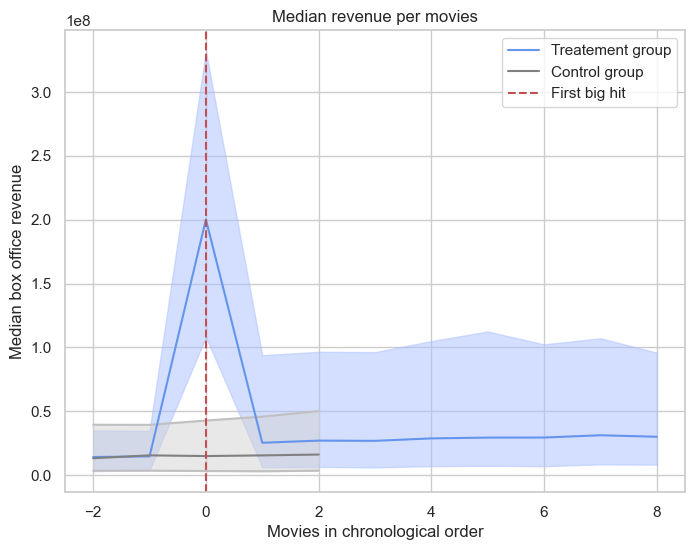

In [66]:
# Compute the mean revenue. Then keep only indexes for which we have enough actors
to_plot_rev_treat = treat_grp.revenue.median()
to_plot_rev_ctrl = ctrl_grp.revenue.median()

# Compute the 25th and 75th quantile for the revenue
Q75_treat = treat_grp.revenue.quantile(q=0.75)
Q25_treat = treat_grp.revenue.quantile(q=0.25)

Q75_ctrl = ctrl_grp.revenue.quantile(q=0.75)
Q25_ctrl = ctrl_grp.revenue.quantile(q=0.25)

# Plot the results
plt.figure(figsize=(8,6))
plt.fill_between(to_plot_rev_treat.index, Q25_treat, Q75_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(to_plot_rev_ctrl.index, Q25_ctrl, Q75_ctrl, alpha = 0.5, color =  'lightgrey')

plt.plot(Q75_ctrl, color='silver')
plt.plot(Q25_ctrl, color='silver')

plt.plot(to_plot_rev_treat, label = 'Treatement group', color='cornflowerblue')
plt.plot(to_plot_rev_ctrl, label = 'Control group', color='grey')

plt.axvline(x=0, color='r', label = 'First big hit', linestyle ='--')
plt.title('Median revenue per movies')
plt.xlabel('Movies in chronological order')
plt.ylabel('Median box office revenue')
plt.legend()
plt.show()

This graph shows the evolution of the median box office revenue along the movies arranged in chronological order. The uncertainty is represented using quantiles (the 25th and the 75th). 

We can see that the median is approximately the same for the two groups before the big hit event. For the big hit movie, as expected, the treatment group (for which the movie was an actual big hit) box office revenue median is much higher than the control group median. What is interesting to see is that, after this first big hit, the median does not fall back to its previous low value but sets, for the next couple of years, to a value that is a bit higher. 

However, there is a lot of variability in the revenue variable and the interquartile range of the treatment and the control group overlaps. This prevents us from having a clear cut and being able to make a strong statement about a difference in the two groups relying only on this graph. We can however see that amoung the treatment group there is a much wider and variable dirstribution of the movie revenue (as seen in the previous plot with the numerous high value outliners).

We will now perform a statistiacl test for the revenue of the movies that comes directly after the first big hit (n=1 and n=2) to see if the difference between the two groups revenue median is significant. However, we will not use a t-test because as we have see our data is not normally distributed and the standard deviation seems to be quite different. We will be using a Wilcoxon signed-rank test instead. One of the reason that we selected this test is that our data is matched.

**Null Hypothesis(H0)**: There is no difference in the median of the movie revenue between the two groups (for n={1, 2})

**Alternative Hypothesis(H1)**:  The median of the movie revenue is bigger for the treatement group than for the control group (for n={1, 2})

In [94]:
# Get subset with n = 1 
after_hit_treat_1 = treat[treat.n == 1]
after_hit_ctrl_1 = ctrl[ctrl.n == 1]

# Get subset with n = 2
after_hit_treat_2 = treat[treat.n == 2]
after_hit_ctrl_2 = ctrl[ctrl.n == 2]

In [111]:
# Perform one-sided Wilcoxon test for n=1
display(scipy.stats.wilcoxon(after_hit_treat_1.revenue, after_hit_ctrl_1.revenue, alternative='greater'))

WilcoxonResult(statistic=2522651.0, pvalue=2.4945913295810143e-41)

In [112]:
# Perform one-sided Wilcoxon test for n=2
display(scipy.stats.wilcoxon(after_hit_treat_2.revenue, after_hit_ctrl_2.revenue, alternative='greater'))

WilcoxonResult(statistic=2482183.5, pvalue=2.149710178680272e-36)

The two p-values of the Wilcoxon tests are well below 0.05 which means that we can reject the null hypothesis with statistical significance level .05. This implies that there is enough evidence in the data to conclude that there is a statistically significant difference (at 0.5 level) between the paired observations for the revenue value (of movies with n={1, 2}).

In [110]:
# Compute the median difference for n={1, 2}
diff_n1 = after_hit_treat_1.revenue.median()-after_hit_ctrl_1.revenue.median()
diff_n2 = after_hit_treat_2.revenue.median()-after_hit_ctrl_2.revenue.median()

# Print the result statement
print(f'The median revenue of movies in the treatment group was found to be significantly higher than that of the control group by ${diff_n1} for n=1 \
and by ${diff_n2} for n=2. This difference was determined to be statistically significant at the 0.05 level.')

The median revenue of movies in the treatment group was found to be significantly higher than that of the control group by $9882885.0 for n=1 and by $10911496.5 for n=2. This difference was determined to be statistically significant at the 0.05 level.


In conclusion, our analysis suggests that the movie revenue of actors after they played in their first big hit is higher than the movie revenue of actors that did not play in a big hit movie.

Out of curiosity let's have a look at those actors who played in multiple outliner big hit movies (with respecto to revenue).

In [32]:
# Merge Q75_treat_reset with plot_treat to associate the Q75 values with the actors and n values
merged_data = pd.merge(plot_treat, Q75_treat, on=['n'], how='left', suffixes=('', '_q75'))

# Create a mask for filtering
mask = merged_data['revenue'] > merged_data['revenue_q75']

# Use the mask to filter the original DataFrame
filtered_data = merged_data[mask]

# Print the names of the actors that have often played in an outliner big hit movie (with respect to revenue)
filtered_data.groupby('name_actor').movieID.count().sort_values(ascending=False)[0:10]

name_actor
Kevin James       10
Seth Rogen         9
Conrad Vernon      8
Bill Nighy         8
Stan Lee           8
Tom Felton         8
Ian McShane        8
Orlando Bloom      8
Cillian Murphy     8
Hugo Weaving       8
Name: movieID, dtype: int64

In the top of this list we find actors that play in general public blockbusters comedies (such as Kevin James and Seth Rogensuch). We also find actors that played in blockbuster series such as Harry Potter (Tom Felton) and Pirates of the Caribbean (Orlando Bloom).

#### IMDb average rating
Let's move on and do the same analysis for the average IMDb rating.

Same as before, we will first get a sense of how this variable is distributed among the two groups. For this we plot the average IMDb rating of the first movie after the first big hit.

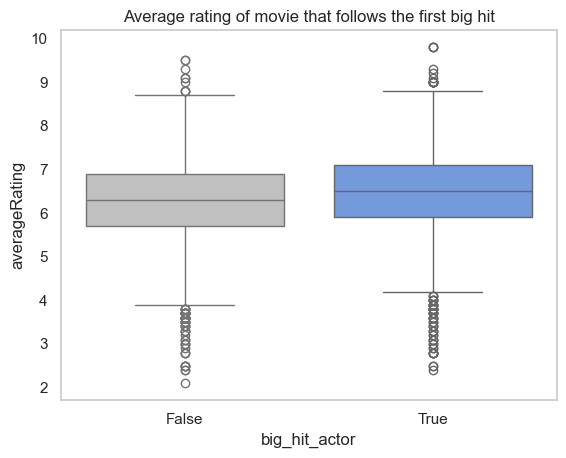

In [33]:
# Plot the average rating for the movie that follows the first big hit in chronological order
plt.title('Average rating of movie that follows the first big hit')
sns.boxplot(x='big_hit_actor', y='averageRating', data=first_after_hit_ctrl, color='silver')
sns.boxplot(x='big_hit_actor', y='averageRating', data=first_after_hit_treat, color='cornflowerblue')
plt.grid(False)
plt.show()

From this plot we can see that the average rating variable seems to be pretty much normally distributed. So we will be using the mean standard deviations for the upcoming plot.

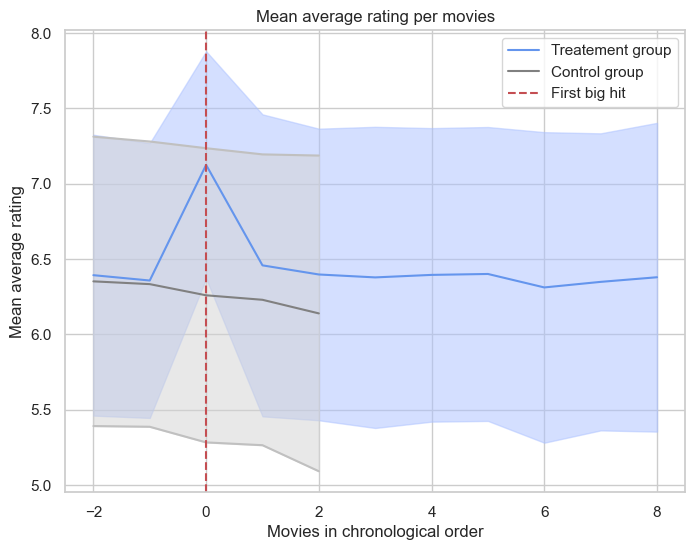

In [51]:
# Compute the mean IMDb rating. Then keep only indexes for which we have enough actors
to_plot_rating_treat = treat_grp.averageRating.mean()
to_plot_rating_ctrl = ctrl_grp.averageRating.mean()

# Do the same with the standard deviation
std_rating_treat = treat_grp.averageRating.std()
std_rating_ctrl = ctrl_grp.averageRating.std()

# Plot the results
plt.figure(figsize=(8,6))

plt.fill_between(to_plot_rating_treat.index, to_plot_rating_treat-std_rating_treat, to_plot_rating_treat+std_rating_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(to_plot_rating_ctrl.index, to_plot_rating_ctrl - std_rating_ctrl, to_plot_rating_ctrl + std_rating_ctrl, alpha = 0.5, color =  'lightgrey')
plt.plot((to_plot_rating_ctrl - std_rating_ctrl), color='silver')
plt.plot((to_plot_rating_ctrl + std_rating_ctrl), color='silver')

plt.plot(to_plot_rating_treat, label = 'Treatement group', color='cornflowerblue')
plt.plot(to_plot_rating_ctrl, label = 'Control group', color='grey')


plt.axvline(x=0, color='r', label = 'First big hit', linestyle ='--')
plt.title('Mean average rating per movies')
plt.xlabel('Movies in chronological order')
plt.ylabel('Mean average rating')
plt.legend()
plt.show()

This graph shows the evolution of the mean of the average IMDb rating along the movies when arranged in chronological order. The uncertainty is represented using the standard devation. 

Similarly as with the revenue variable, we can see that the mean is approximately the same for the two groups before the big hit event. At the big hit movie, the treatment group (for which the movie was an actual big hit) IMDb rating mean rises (unsurprisingly) above the control group mean. After the big hit event, the mean of the control group returns to its previous value. This is in contrast with the control group mean which seems to decrease.

However, the means of the two groups are always quite close to one another (the difference in average rating is less than 1) and the two group's standard deviation strongly overlap. For this reason we cannot conclude that there is any difference between the two groups. It would be interesting to have more data for the control group to know if the average rating tendency to drop actually continues or if it is only random data variation.

#### Success
Let's now continue our analysis by looking at the success value.

Again, we will first get a sense of how this variable is distributed among the two groups. For this we plot the success value of the first movie after the first big hit.

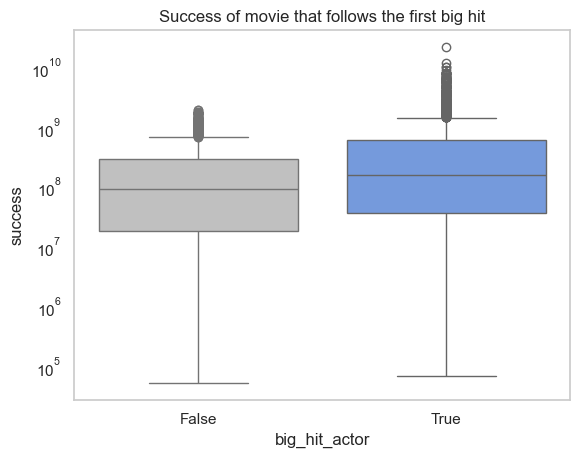

In [35]:
# Plot the average rating for the movie that follows the first big hit in chronological order
plt.title('Success of movie that follows the first big hit')
sns.boxplot(x='big_hit_actor', y='success', data=first_after_hit_ctrl, color='silver')
sns.boxplot(x='big_hit_actor', y='success', data=first_after_hit_treat, color='cornflowerblue')
# Plot in log scale to have better visibility 
plt.yscale('log')
plt.grid(False)
plt.show()

As we can see from this plot the success value is not normally distributed and it contains many extreme outliners (note log scale of the y-axis). It also seems that the treatment group success value is more skewed than for the control group. So when plotting the revenue for each 'n' we will rather use the median instead of the mean and quantiles instead of standard deviation.

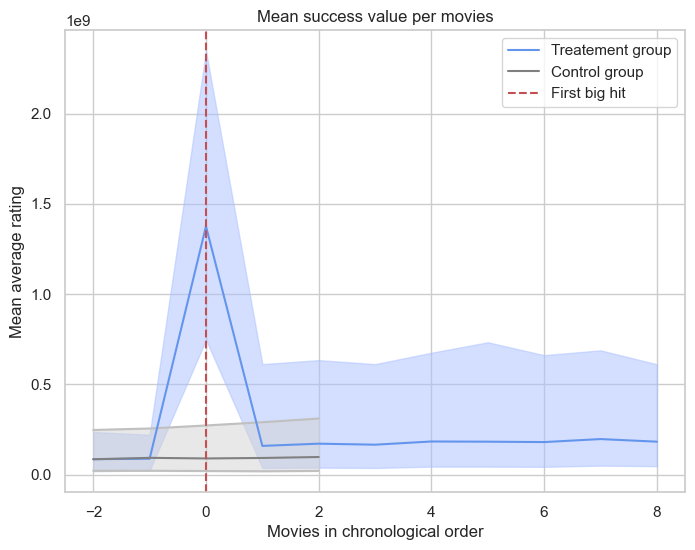

In [36]:
# Compute the mean success value. Then keep only indexes for which we have enough actors
to_plot_success_treat = treat_grp.success.median()[to_plot_indexes_treat]
to_plot_success_ctrl = ctrl_grp.success.median()[to_plot_indexes_ctrl]

# Compute the 25th and 75th quantile for the success value
Q75_treat = treat_grp.success.quantile(q=0.75)
Q25_treat = treat_grp.success.quantile(q=0.25)

Q75_ctrl = ctrl_grp.success.quantile(q=0.75)
Q25_ctrl = ctrl_grp.success.quantile(q=0.25)

# Plot the results
plt.figure(figsize=(8,6))
plt.fill_between(to_plot_success_treat.index, Q25_treat, Q75_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(to_plot_success_ctrl.index, Q25_ctrl, Q75_ctrl, alpha = 0.5, color =  'lightgrey')

plt.plot(Q25_ctrl, color='silver')
plt.plot(Q75_ctrl, color='silver')

plt.plot(to_plot_success_treat, label = 'Treatement group', color='cornflowerblue')
plt.plot(to_plot_success_ctrl, label = 'Control group', color='grey')


plt.axvline(x=0, color='r', label = 'First big hit', linestyle ='--')
plt.title('Mean success value per movies')
plt.xlabel('Movies in chronological order')
plt.ylabel('Mean average rating')
plt.legend()
plt.show()

This graph shows the evolution of the median success value along the movies arranged in chronological order. The uncertainty is represented using quantiles (the 25th and the 75th). 

This graph is very similary to the one from the analysis of the revenue evolution. We can also notice that the median is approximately the same for the two groups before the big hit event. For the big hit movie, as expected, the treatment group median success value is much higher than the control group median. Similarily as for the revenue and the IMDb rating analysis we observe that, after this first big hit, the median does not fall back to its previous low value but sets, for the next couple of years, to a value that is a bit higher. 

However, the two median are close to one another even after the big hit event. Moreover there is a lot of variability in the two groups (especially in the treatment group) and their interquartile range overlaps. This prevents us from having a clear cut and being able to make a strong statement about a difference in the two groups relying only on this graph. We can however see that amoung the treatment group there is a much wider and variable dirstribution of the movie revenue (as seen in the previous plot with the numerous high-value outliners).

We will now perform a statistiacl test for the revenue of the movies that comes directly after the first big hit (n=1 and n=2) to see if the difference between the two groups success median is significant. However, we will not use a t-test because as we have see our data is not normally distributed and the standard deviation seems to be quite different. We will be using a Wilcoxon signed-rank test instead. One of the reason that we selected this test is that our data is matched.

**Null Hypothesis(H0)**: There is no difference in the median of the movie success value between the two groups (for n={1, 2})

**Alternative Hypothesis(H1)**:  The median of the movie success value is bigger for the treatement group than for the control group (for n={1, 2})

In [103]:
## Perform one-sided Wilcoxon test for n=1
display(scipy.stats.wilcoxon(after_hit_treat_1.success, after_hit_ctrl_1.success, alternative='greater'))

WilcoxonResult(statistic=2541043.0, pvalue=6.74624599838967e-44)

In [104]:
# Perform one-sided Wilcoxon test for n=2
display(scipy.stats.wilcoxon(after_hit_treat_2.revenue, after_hit_ctrl_2.revenue, alternative='greater'))

WilcoxonResult(statistic=2482183.5, pvalue=2.149710178680272e-36)

The two p-values of the Wilcoxon tests are well below 0.05 which means that we can reject the null hypothesis with statistical significance level .05. This implies that there is enough evidence in the data to conclude that there is a statistically significant difference (at 0.5 level) between the paired observations for the success value (of movies with n={1, 2}).

In [109]:
# Compute the median difference for n={1, 2}
diff_n1 = after_hit_treat_1.success.median()-after_hit_ctrl_1.success.median()
diff_n2 = after_hit_treat_2.success.median()-after_hit_ctrl_2.success.median()

# Print the result statement
print(f'The median success value of movies in the treatment group was found to be significantly higher than that of the control group by {diff_n1:.2f} \
for n=1 and by {diff_n2:.2f} for n=2. This difference was determined to be statistically significant at the 0.05 level.')

The median success value of movies in the treatment group was found to be significantly higher than that of the control group by 66886986.65 for n=1 and by 73837455.75 for n=2. This difference was determined to be statistically significant at the 0.05 level.


In conclusion, our analysis suggests that the movie success value of actors after they played in their first big hit is higher than the movie success value of actors that did not play in a big hit movie.

### Career genres analysis
Now let's look at the genres of the different movies actors played in and how they change from one movie to another.

We first have to convert the genre column from strings to bags of words. For this we first use the function we defined in helpers called parse_genres which safely parses the genres string and extracts genre names. We then use the Counter function from collections library to finally end up with bags of words.

In [37]:
# Compute the number of movies that do not have any genre value to assess the amount of missing information
nb_movies_no_genre = df_career_analysis[df_career_analysis['genres'] == '{}'].movieID.nunique()

# Use the parse_genres function defined in helpers file to parse strings and extract genre names
df_career_analysis['parsed_genres'] = df_career_analysis['genres'].apply(parse_genres)

# For the gernes column, replace the list by a bag of words using the Counter function
df_career_analysis['genres'] = df_career_analysis.parsed_genres.apply(lambda x: Counter(x))

# Get rid of unwanted column
df_career_analysis = df_career_analysis.drop(labels='parsed_genres', axis=1)

# Print the number of movies lost
print(f'The number of movies that have no information on genre is: {nb_movies_no_genre}, this represents \
{nb_movies_no_genre*100/df_career_analysis.movieID.nunique(): .2f}% of the movies. For those movies the genre was set to "No genre"')

The number of movies that have no information on genre is: 1, this represents  0.02% of the movies. For those movies the genre was set to "No genre"


There is only one movie for which we do not have genre data. Since this represents only a small fraction of the movies we have, we can ignore this and carry on with our analysis.

Now we want to compare different genre bag of words. To do so we must define a similarity function to use. The different movies have different level of genre description; some are short bag of words (e.g. {Drama: 1}), some are medium-length bag of words (e.g. {Drama: 1, Romance: 1}), and some are longer bag of words (e.g. {Drama: 1, Horror: 1, War film: 1}). But all three previous bag of words should have the same similarity since they all have only one genre in common and nothing else. Following this reasoning we decided to compute the similarity by simply counting the number of words that are the same in the two bag of words that we are comparing, without penalizing their length. The function that takes care of this is called 'dotproduct_similarity' and can be found in the helpers file

We still have to decide which pair of movies we will compare for our analysis. For each movie, we decided to compute the similarity with the two previous movies (in chronological order) and keep the mean value: similarity value for movie[n] = 0.5*(similarity(movie[n], movie[n-1]) + similarity(movie[n], movie[n-2])). 

In [38]:
# Group our dataframe by the names of the actors
grp = df_career_analysis.groupby('name_actor')

# Compute the similarity of the genres of each movie with the genres of the two movies that come before in chronological order
df_career_analysis['similarity'] = grp.apply(lambda x: x.apply(
    lambda row: similarity_two_prev_movie(x, row), axis=1)).reset_index(drop=True)
df_career_analysis['similarity'] = df_career_analysis['similarity'].astype(float)

Now that we have calculated the similarity values we can plot them. We will use boxplots to have a good representation of the variable distribution.

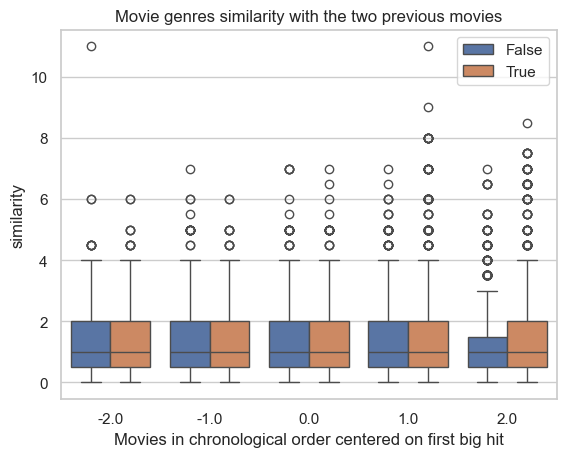

In [63]:
# Plot the boxplots for each representative n index
df_career_analysis_plot = df_career_analysis[df_career_analysis.n.isin(to_plot_indexes_ctrl)]
sns.boxplot(df_career_analysis_plot, x='n', y='similarity', hue='big_hit_actor')
plt.title('Movie genres similarity with the two previous movies')
plt.xlabel('Movies in chronological order centered on first big hit')
plt.legend()
plt.show()

As we can clearly see from this graph there is no real difference between the treatment and control group for the similarity between genres of successive movies played by an actor. Furthermore, we cannot notice a strong difference between before and after the first big hit event.

### Career role analysis

In [ ]:
df_career_analysis.columns

In [ ]:
for_hist = df_career_analysis[df_career_analysis.n.isin(list([-1, 0, 1, 2]))]
sns.boxplot(for_hist, x='n', y='role_importance', hue='big_hit_actor')

In [ ]:
plt.scatter(for_hist.n, for_hist.revenue, s=80, alpha=0.05, c=for_hist.big_hit_actor, cmap= 'seismic')

In [ ]:
treat = df_career_analysis[df_career_analysis.big_hit_actor]
ctrl = df_career_analysis[~df_career_analysis.big_hit_actor]

In [ ]:
treat_grp = treat.groupby('n')
ctrl_grp = ctrl.groupby('n')

n_to_plot_treat = treat_grp.role_importance.count()[treat_grp.role_importance.count()>700].index
n_to_plot_ctrl = ctrl_grp.role_importance.count()[ctrl_grp.role_importance.count()>700].index

if len(n_to_plot_treat) < len(n_to_plot_ctrl):
    n_to_plot = n_to_plot_treat
else: n_to_plot = n_to_plot_ctrl

df_career_analysis_with_role = df_career_analysis[df_career_analysis.n.isin(n_to_plot)]
list_actor_no_data = df_career_analysis[df_career_analysis.role_importance.isna()].name_actor.unique()
list_matched_no_data = df_career_analysis[df_career_analysis.name_actor.isin(list_actor_no_data)].matched_name.unique()
tot_list_no_data = list_actor_no_data+list_matched_no_data
print(len(tot_list_no_data))
df_career_analysis_with_role = df_career_analysis_with_role[df_career_analysis_with_role.name_actor.isin(tot_list_no_data)]

-> Not enough data to say anything

In [ ]:
treat = df_career_analysis_with_role[df_career_analysis_with_role.big_hit_actor]
ctrl = df_career_analysis_with_role[~df_career_analysis_with_role.big_hit_actor]

treat_grp = treat.groupby('n')
ctrl_grp = ctrl.groupby('n')


Q75_treat = treat_grp.role_importance.quantile(q=0.75)
Q25_treat = treat_grp.role_importance.quantile(q=0.25)

Q75_ctrl = ctrl_grp.role_importance.quantile(q=0.75)
Q25_ctrl = ctrl_grp.role_importance.quantile(q=0.25)

plt.fill_between(n_to_plot_treat.values, Q25_treat, Q75_treat, alpha = 0.5, color = (0.67, 0.757, 1))
plt.fill_between(n_to_plot_ctrl.values, Q25_ctrl, Q75_ctrl, alpha = 0.5, color =  'lightgrey')

plt.plot(treat_grp.role_importance.median())
plt.plot(ctrl_grp.role_importance.median())